In [7]:
import sys
sys.path.append('/home/axf295/2019/code/spt3g_software/polcal/python/')
sys.path.append('/home/axf295/2019/code/spt3g_software/build/')
from spt3g import core,std_processing
import CenA_Map_Utils as CMU
import General_Utils  as GU
import Polarization_Fitting as PF
import Plotting_Utils as PU


from matplotlib import pylab as pl
import numpy as np
import pickle as pk



In [8]:
## Set wafers to analyze by adding/removing from this list
wafer_colors_18 = {'W188':'c', 'W174':'b', 'W177':'purple', 'W176':'y', 'W172':'k', 'W180':'orange', 'W181':'brown','W203':'r'}## Removed w2xx #'w203':'r', 'w201':'g',  'w187':'darkblue'

wafer_colors_19 = {'W172':'r', 'W174':'g', 'W176':'c', 'W177':'b', 'W180':'purple', 'W181':'y', 'W188':'k', 'W203':'orange', 'W204':'brown', 'W206':'darkblue'}

## Constants for plotting, etc.
bandmarkers = {'90':'s','150':'o','220':'*'}        
bandcolors  = {'90':'b','150':'g','220':'r'}  
bandfig     = {'90':1,'150':2,'220':3}
bands       = ['90','150','220']
maptypes    = ['T','Q','U']



## Static data locations
singlebolomap_loc = '/spt/user/production/calibration/CenA-pixelraster/singlebolomaps/'
coaddmap_loc      = '/spt/user/production/calibration/CenA-pixelraster/coaddmaps/'
calframe_loc      = '/spt/user/production/calibration/calframe/CenA-pixelraster/' #'/spt/user/production/calibration/boloproperties/60000000.g3'

In [9]:
obsids = ['72096094']

sn_cuts = {}
sn_cuts['90'] = [10.,1.]
sn_cuts['150'] = [10.,1.]
sn_cuts['220'] = [2.,1.]

## By-eye cuts looking at noise/pixel in Noise_Mask Region for good observations
## set stupidly high because S/N cuts usually do the job
noise_cuts = {'90':5000, '150':5000, '220':20000}    
    
## Arbitrary cut based on CenA Brightness, for filtering out a noise spike
peakbrightnesscut = 300
numgoodboloscut   = 3000





Analyzing 72096094


/home/axf295/2019/code/spt3g_software/build/spt3g/core/skymapaddons.py:25: RuntimeWarning: invalid value encountered in true_divide
  return numpyinplace(a, numpy.ndarray.__dict__[op](numpy.asarray(a), numpy.asarray(b)))


90 : 3.36354151176 +- 0.664192540393

150 : 2.54688604062 +- 0.411838512924

220 : 10.5925896107 +- 1.5447372637



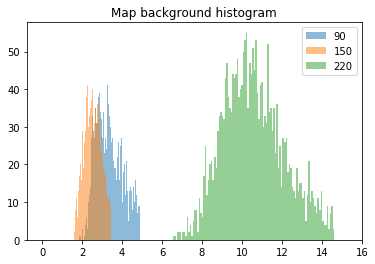

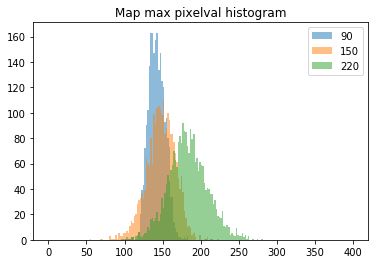

In [11]:
failed_obs = {}
for ob in sorted(obsids):
    

    data_dir = '/big_scratch/axf295/2019/CenA/Analyzed_Data/%s/'%ob
    
    print('Analyzing %s'%ob)
    ## Start Logger
    
    
    ## Choose wafers
    if ob == 'All':
        usecoupling = True
        wafers = sorted(wafer_colors_19)
    elif int(ob)>60000000:
        usecoupling = True
        wafers = sorted(wafer_colors_19)
    else:
        usecoupling = False
        wafers = sorted(wafer_colors_18)

    if ob != 'All':
        ## assume this for now... it's accurate enough for 2019 data.
        numframes = 14000
        num_bolos = numframes-3
        ind_map_data = core.G3File(singlebolomap_loc+'%s.g3'%(ob))

        ## Load bolometer properties
        cal_file = calframe_loc+'%s.g3'%ob
        bolo2band,pname,AB,nominal_angles,unique_nominal_angles,coupling = GU.load_bolometer_properties(cal_file)
        
        ## Load the SN calculated in a previous script
        ## Load the center locations
        try:
            bolo_nuclear_sn = pk.load(open(data_dir+'Source_Signal_Dictionary.pkl','rb'))
            bolo_noise      = pk.load(open(data_dir + 'Bolo_Noise_Dictionary.pkl','rb'))
            center_locs     = pk.load(open(data_dir+'CenA_center_location_Dictionary.pkl','rb'))
            
        except Exception:
            print('Couldnt load a file')
            print(output_dir)
            continue
        ## Set the center location of the source.    
        xo = int(np.nanmedian(center_locs['x']))
        yo = int(np.nanmedian(center_locs['y']))

        ## Load autoprocessed TQU maps ; per band coadds only
        coaddfile = coaddmap_loc+'%s.g3'%ob
        template_tqu_maps    = CMU.load_perband_coaddmaps(coaddfile,factor=1./core.G3Units.mK,xo=xo,yo=yo)
    
        

        crapsignalbolos = []
        noiseybolos     = []
        bolo_maps       = {}
        maxpixval       = {}
        improperly_shaped_maps = []
        prob_zero_or_nansinmap = []
        is_resistor            = []
        is_dark                = []
        background = {}
        map_sn     = {}
        for band in bands:
            maxpixval[band]  = []
            background[band] = []
            map_sn[band]     = []
        ## Loop through frames and analyze individual maps
        ## if not map frame, continue
        ## if problematic/noisy bolo, continue
        while True:
            try:
                fr = ind_map_data.next()
                if 'Wunpol' in fr:
                    b = fr['Id']
                    if b == 'map':
                        continue

                    ## Do not include dark bolos, or resistors in bolo_maps
                    if b not in bolo2band or b not in coupling:
                        continue
                    if bolo2band[b] == -1:
                        is_resistor.append(b)
                        continue
                    if usecoupling:
                        if str(coupling[b]) != 'Optical':
                            is_dark.append(b)
                            continue
                    else:
                        pass
                    bolo_maps[b] = CMU.CenAMap(fr)
                    #bolo_maps[b].get_brightest_pixel()
                    bolo_maps[b].center_map(xo=xo,yo=yo)
                    
                    bmt = bolo_maps[b].maps['T']
                    
                    
                    if b in bolo_nuclear_sn and b in bolo_noise and ~np.any(np.isnan(bmt)):
                        bolo_maps[b].band   = str(bolo2band[b])
                        bolo_maps[b].nomang = int(nominal_angles[b])
                        bolo_maps[b].wafer  = pname[b].split('_')[0].upper()
                        noise = bolo_noise[b]#CMU.calc_source_masked_variance(bolo_maps[b].maps['T'],1.-mask[bolo_maps[b].band])

                        if np.isnan(noise) or noise == 0. or noise == -1 :
                            prob_zero_or_nansinmap.append(b)
                            continue
                        elif  not CMU.map_is_square(bmt):
                            improperly_shaped_maps.append(b)
                            continue
                        elif noise > noise_cuts[band] :
                            noiseybolos.append(b)
                            continue

                        bnsn = bolo_nuclear_sn[b][0]/bolo_nuclear_sn[b][1]
                        if bnsn < sn_cuts[bolo_maps[b].band][0]  or np.amax(bmt) > peakbrightnesscut:
                            crapsignalbolos.append(b)
                        else:
                            bolo_maps[b].noise = noise
                            bolo_maps[b].sn = bnsn
                            map_sn[bolo_maps[b].band].append(bolo_maps[b].sn)
                            background[bolo_maps[b].band].append(noise)
                            maxpixval[bolo_maps[b].band].append(np.amax(bmt))

                    else:    
                        prob_zero_or_nansinmap.append(b)
            except StopIteration:
                break
       
        mapvar3sigmaupper = {}

       
        pl.figure()
        for band in background:
            #print(background[band])
            cleanedbackground = GU.remove_outliers(background[band])
            mapvar3sigmaupper[band] = np.nanmean(cleanedbackground)+3*np.nanstd(cleanedbackground)
            print(band+' : '+str(np.nanmean(cleanedbackground))+' +- '+str(np.nanstd(cleanedbackground))+'\n')
            pl.hist(cleanedbackground,bins=np.linspace(0,mapvar3sigmaupper[band],201),alpha=.5,label=band)


        pl.legend()
        pl.title('Map background histogram')
        #pl.savefig(output_dir+'%s_MapBackHist.png'%(ob))
        pl.show()
        

       
        pl.figure()
        for band in maxpixval:
            pl.hist(maxpixval[band],bins=np.linspace(0,400,201),alpha=.5,label=band)

        pl.legend()
        pl.title('Map max pixelval histogram')
        #pl.savefig(output_dir+'%s_MapMaxPixValHist.png'%(ob))
        pl.show()
        goodbolos = []
        ## Build a list of good bolos which pass the cuts
        for b in bolo_maps:
            if  bolo_maps[b].noise > mapvar3sigmaupper[band]:
                noiseybolos.append(b)
            else:
                if b not in crapsignalbolos and b not in improperly_shaped_maps and b not in prob_zero_or_nansinmap and b not in noiseybolos and b not in is_dark and b not in is_resistor:
                    goodbolos.append(b)



        if len(goodbolos)<numgoodboloscut:
            continue
            
        ## Make nominal angle coadds (split per-wafer and per-band)
        nomang_coadds,numbolos_per_nomang = CMU.make_nominalangle_coadds(bolo_maps,wafers,goodbolos = goodbolos)    

1 90 0.207978618637
1 150 0.13886944186
1 220 0.311891441329
46 90 0.194870645135
46 150 0.139605224895
46 220 0.305168302232
91 90 0.196689083679
91 150 0.139266410541
91 220 0.300977168346
136 90 0.212747463552
136 150 0.125242992665
136 220 0.315004477445
16 90 0.222119708354
16 150 0.159675664417
16 220 0.302178789029
61 90 0.220115827782
61 150 0.138266888751
61 220 0.299901573355
106 90 0.213368115124
106 150 0.148434897656
106 220 0.312450364329
151 90 0.220466893324
151 150 0.144493424984
151 220 0.298740731362
31 90 0.262134332133
31 150 0.228499368284
31 220 0.311770760331
76 90 0.265334689405
76 150 0.228319874074
76 220 0.308975172286
121 90 0.268054599785
121 150 0.234485933629
121 220 0.314751403565
166 90 0.275110061107
166 150 0.231791332282
166 220 0.305334158255
16 90 0.232793115984
16 150 0.163194208331
16 220 0.317567799359
61 90 0.235345104395
61 150 0.169955276084
61 220 0.309876513587
106 90 0.233635447883
106 150 0.160720680555
106 220 0.303632766658
151 90 0.22

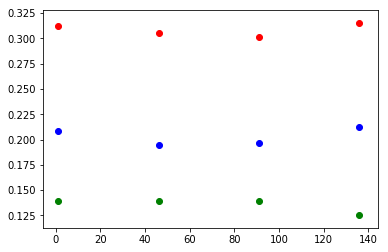

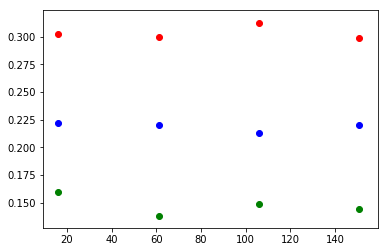

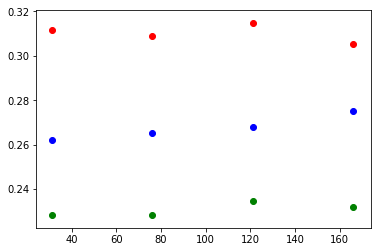

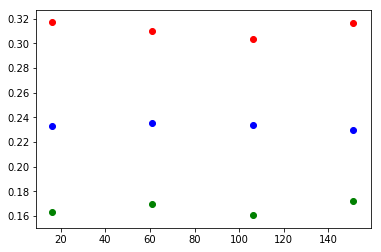

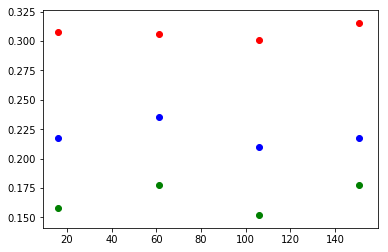

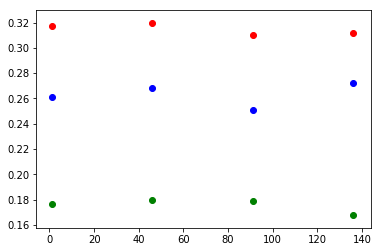

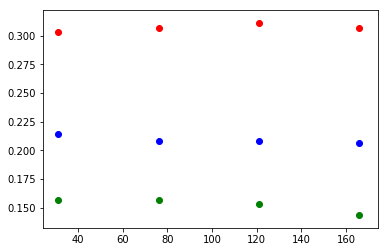

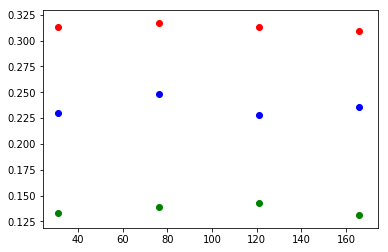

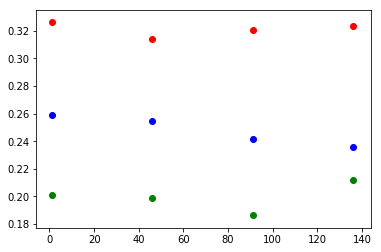

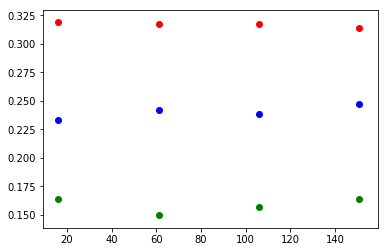

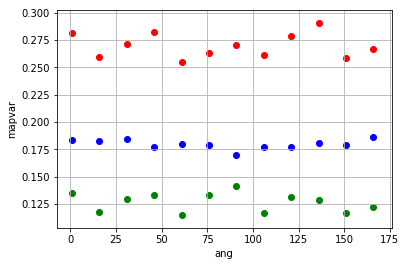

In [38]:
def calc_source_masked_variance(bolo_map,Noise_Mask=''):

    '''
    Calculate the variance of a masked map
    Checks the shapes of both maps and does the right thing.
    
    Arguments
    ---------
    bolo_map : 2D numpy array
        map to be masked and to of which to find the variance
        
    noise_mask : 2D numpy array
        mask map; multiplies bolo_map to mask source.
    
    Returns
    -------
    variance: float
        variance of the masked map (where bolo_map*noise_mask !=0)
        
    '''

    if Noise_Mask == '':
        Noise_Mask = np.zeros(np.shape(bolo_map))
        Noise_Mask[np.where(abs(bolo_map)>1.)]+=1.
        Noise_Mask = 1.0-Noise_Mask
    ms = np.shape(Noise_Mask)[0]
    dsx = np.shape(bolo_map)[0]
    dsy = np.shape(bolo_map)[1]
    if dsx > ms or dsy > ms:
        bolo_map = bolo_map[dsx//2-ms//2:dsx//2+ms//2, dsy//2-ms//2:dsy//2+ms//2]
        bolonoisemask = Noise_Mask
    elif dsx < ms or dsy < ms:
        bolonoisemask = Noise_Mask[ms//2-dsx//2:ms//2+dsx//2, ms//2-dsy//2:ms//2+dsy//2]
    else:
        bolonoisemask = Noise_Mask
        
    #plt.imshow(bolonoisemask);plt.show()
    #plt.imshow(bolonoisemask*bolo_map);plt.colorbar();plt.show()
    try:
        variance = np.nanvar(bolo_map[np.nonzero(bolonoisemask)])
    except IndexError:
        variance = -1
    return variance

plt = pl
for wafer in nomang_coadds:
    plt.figure()
    for ang in sorted(nomang_coadds[wafer]):
        for band in nomang_coadds[wafer][ang]:
            #print(nomang_coadds[wafer][ang][band])
            #plt.imshow(nomang_coadds[wafer][ang][band]);plt.colorbar()
            #plt.show()

            mapvar = calc_source_masked_variance(nomang_coadds[wafer][ang][band])#np.var(nomang_coadds[wafer][ang][band][60:,60:])#
            print(ang,band,mapvar)
            plt.scatter(ang,mapvar,color=bandcolors[band])
            #imdat = np.copy(allcoadds[ang][band])
            #imdat[abs(imdat)>1.] = 0.
            #plt.imshow(imdat);plt.colorbar()
            #print(np.nanvar(imdat))
plt.grid()
plt.xlabel('ang')
plt.ylabel('mapvar')
plt.show()

KeyboardInterrupt: 

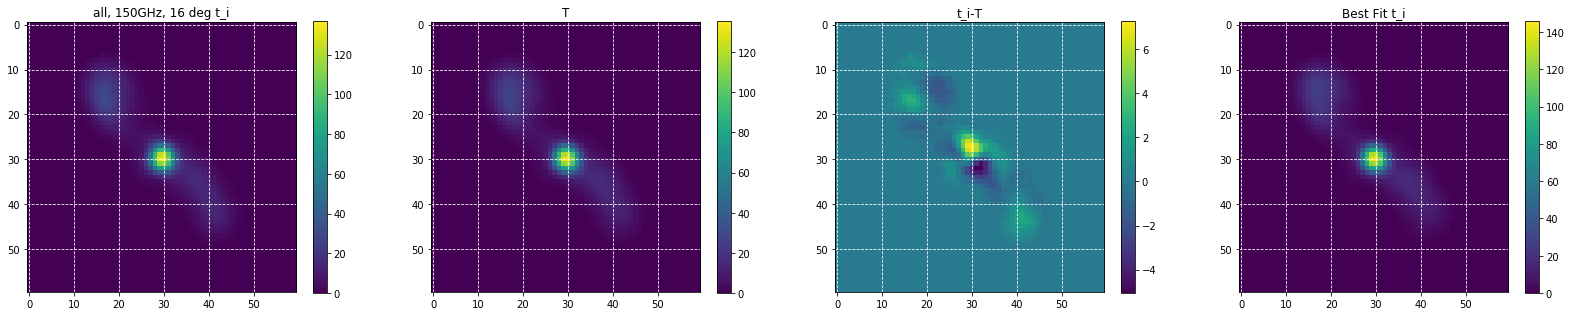

In [33]:
perbandcoadds = {}
## HARDCODED!! WARNING!! IF MAPSIZE CHANGES, THIS NEEDS TO CHANGE!    
ps = int(40) ## proper mapsize
proper_size = (ps,ps) ## Size of individual bolo maps  
mapsize = ps//2 ## Half length of map side, in pixels

## Load CenA Mask
mask = {}
nucleusR = {'90':8,'150':6,'220':5}
for band in bands:
    mask[band] = np.loadtxt('/home/axf295/2019/code/spt3g_software/polcal/Masks/0p25arcmin/'+'%sGHz_Amp_Mask.txt'%band)
    masksize = np.shape(mask[band])[0]//2
    #mask[band][masksize-nucleusR[band]:masksize+nucleusR[band],masksize-nucleusR[band]:masksize+nucleusR[band]] *= 0.
    
log=open('fakelog.txt','w')
mapsize=30
PLOT = 1
nomangfitdata = PF.fit_nominal_angle_coadd_polarization(nomang_coadds,perbandcoadds,template_tqu_maps,
                                                            mask,numbolos_per_nomang,log,
                                                            mapsize=mapsize,variable='g',
                                                            plot_loc='./',PLOT=PLOT)